# DMD analysis of surface and slice data with flowTorch

- reading snapshot surface/slice data in Python
- building the data matrix
- SVD and DMD analysis

In [134]:
from os import makedirs
from os.path import join
import torch as pt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation, FFMpegWriter
from scipy.signal import welch
from flowtorch.data import CSVDataloader, mask_box
from flowtorch.analysis import SVD, DMD

plt.rcParams["figure.dpi"] = 160
output = "output"
makedirs(output, exist_ok=True)

## $x$-$y$-plane (wake)

### Loading the data, first visualization

In [46]:
path = "run/surfaceMountedCube/fullCaseDMD/postProcessing/surface1/"
loader = CSVDataloader.from_foam_surface(path, "U_plane_xy.raw")
times = loader.write_times
times_num = pt.tensor([float(t) for t in times])
fields = loader.field_names[times[0]]
vertices = loader.vertices[:, :2]
print(f"time interval: [{times[0]}, {times[-1]}] ({len(times)})")
print("Available fields: ", fields)
print(f"Field size: {vertices.shape[0]}")

time interval: [30.06, 89.94] (999)
Available fields:  ['U_x', 'U_y', 'U_z']
Field size: 35154


In [21]:
vel = loader.load_snapshot(fields, times)

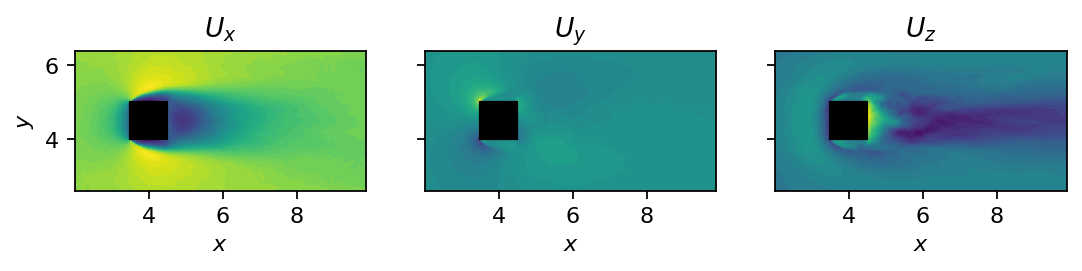

In [44]:
x, y = vertices[:, 0], vertices[:, 1]

fig, axarr = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)
titles = [r"$ U_{:s} $".format(i) for i in ("x", "y", "z")]
for i, vi in enumerate(vel):
    axarr[i].tricontourf(x, y, vi.mean(dim=1), levels=50)
    axarr[i].set_aspect("equal")
    axarr[i].set_xlabel(r"$x$")
    cube = Rectangle((3.5, 4), 1, 1, linewidth=1, edgecolor="k", facecolor="k")
    axarr[i].add_patch(cube)
    axarr[i].set_title((titles[i]))
axarr[0].set_ylabel(r"$y$")
plt.show()

### Data matrix and weighting

In [49]:
n_points, n_times = x.shape[0], len(times)
dm = pt.zeros((3*n_points, n_times))
dm[:n_points, :] = vel[0]
dm[n_points:2*n_points, :] = vel[1]
dm[2*n_points:, :] = vel[2]

In [59]:
area = loader.weights
dmw = dm * area.repeat(3).unsqueeze(-1)

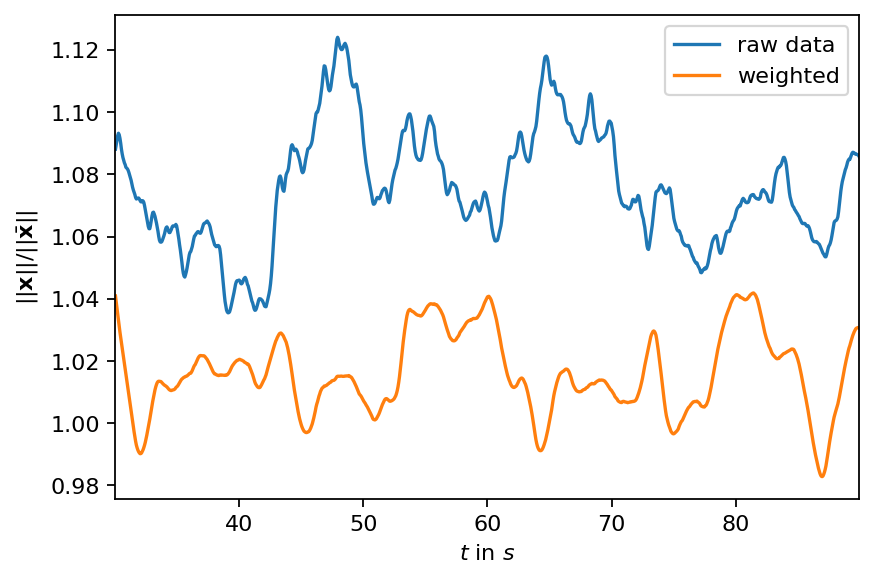

In [63]:
plt.plot(times_num, dm.norm(dim=0)/dm.mean(dim=1).norm(), label="raw data")
plt.plot(times_num, dmw.norm(dim=0)/dmw.mean(dim=1).norm(), label="weighted")
plt.xlabel(r"$t$ in $s$")
plt.ylabel(r"$||\mathbf{x}||/||\bar{\mathbf{x}}||$")
plt.xlim(times_num[0], times_num[-1])
plt.legend()
plt.show()

### Proper orthogonal decomposition (POD)

In [65]:
svd = SVD(dmw, rank=1000)
print(svd)

SVD of a 105462x999 data matrix
Selected/optimal rank: 999/435
data type: torch.float32 (4b)
truncated SVD size: 405.7142Mb


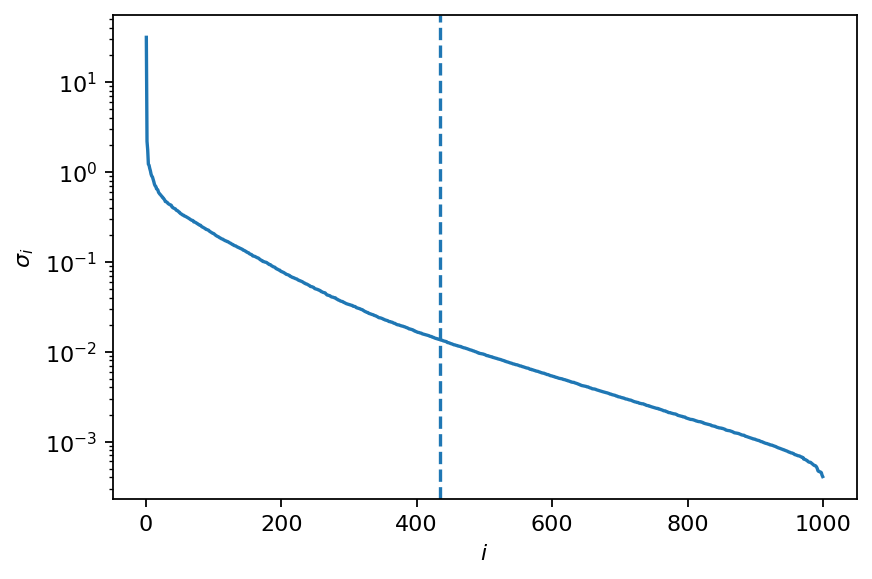

In [68]:
plt.plot(range(1, n_times+1), svd.s_rel)
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_i$")
plt.axvline(svd.opt_rank, ls="--")
plt.yscale("log")
plt.show()

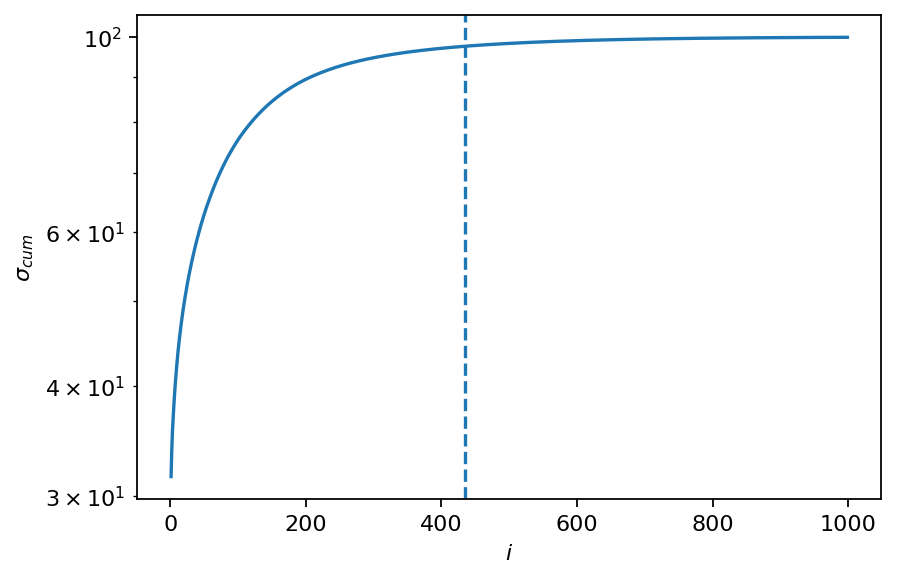

In [70]:
plt.plot(range(1, n_times+1), svd.s_cum)
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{cum}$")
plt.axvline(svd.opt_rank, ls="--")
plt.yscale("log")
plt.show()

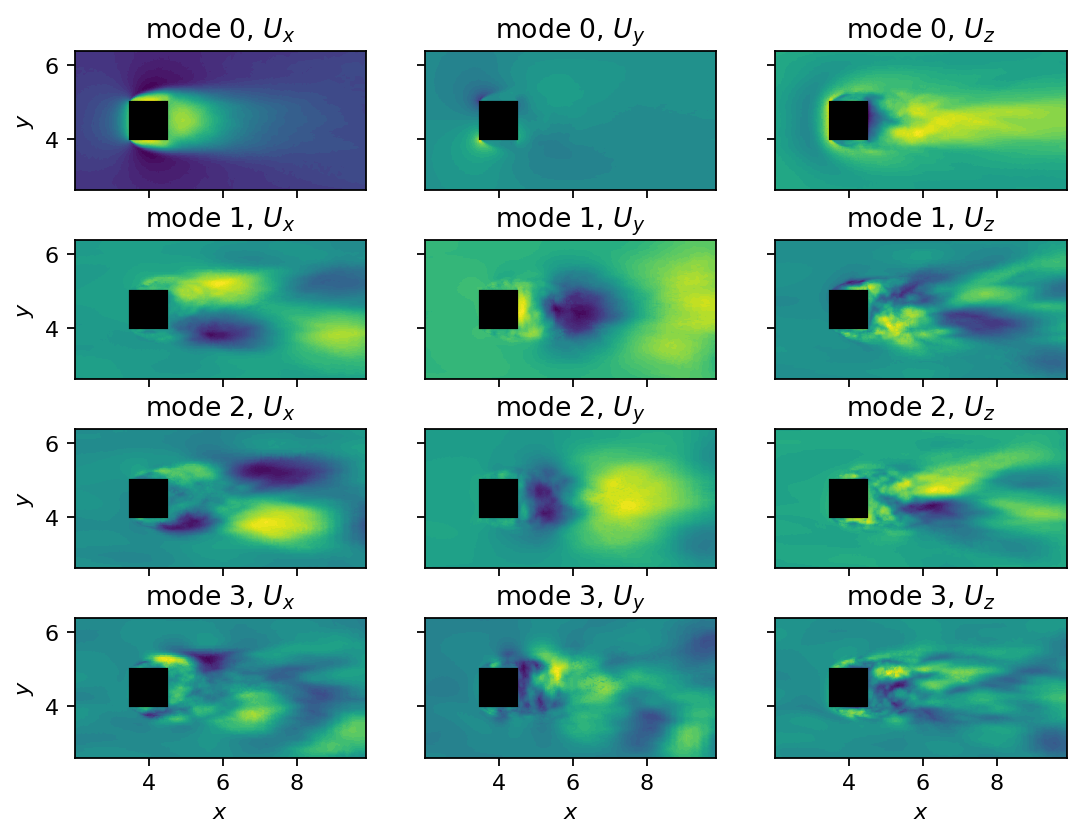

In [76]:
n_plot = 4
fig, axarr = plt.subplots(n_plot, 3, figsize=(8, 1.5*n_plot), sharex=True, sharey=True)
for i in range(n_plot):
    axarr[i, 0].tricontourf(x, y, svd.U[:n_points, i]/area, levels=50)
    axarr[i, 1].tricontourf(x, y, svd.U[n_points:2*n_points, i]/area, levels=50)
    axarr[i, 2].tricontourf(x, y, svd.U[2*n_points:, i]/area, levels=50)
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        cube = Rectangle((3.5, 4), 1, 1, linewidth=1, edgecolor="k", facecolor="k")
        ax.add_patch(cube)
        axarr[i, 0].set_ylabel(r"$y$")
    axarr[i, 0].set_title(f"mode {i}, $U_x$")
    axarr[i, 1].set_title(f"mode {i}, $U_y$")
    axarr[i, 2].set_title(f"mode {i}, $U_z$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$x$")
plt.show()

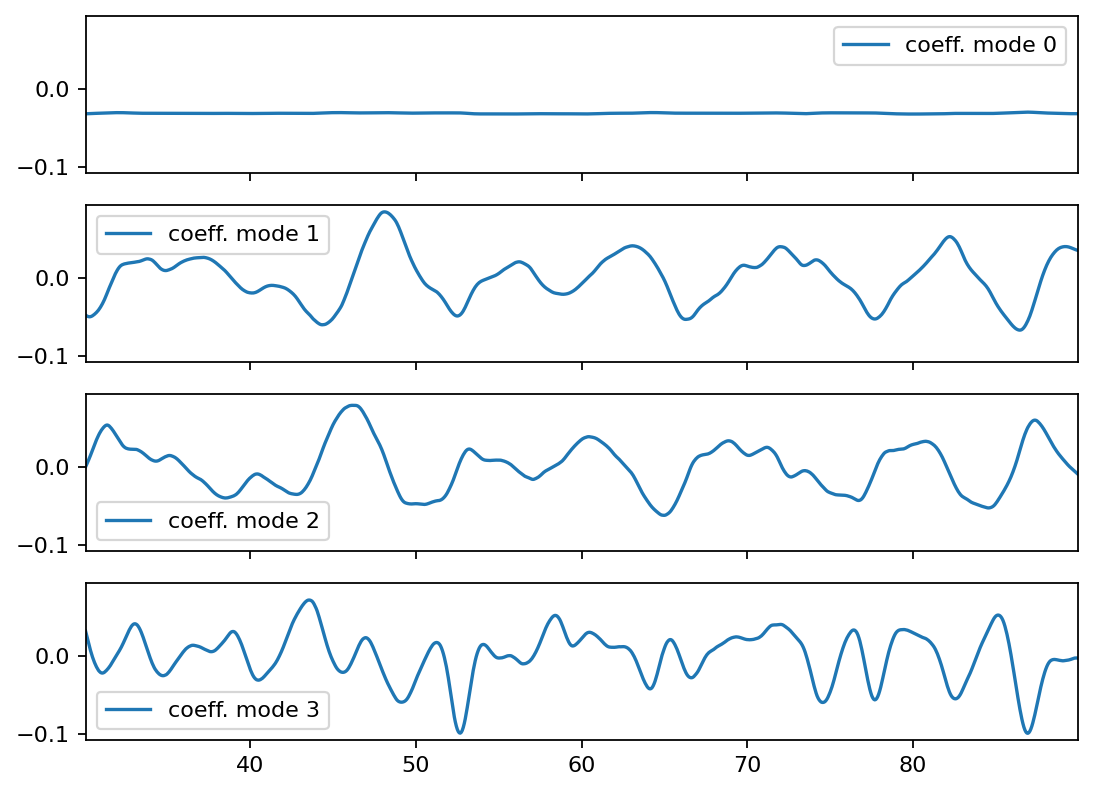

In [80]:
fig, axarr = plt.subplots(n_plot, 1, figsize=(8, 1.5*n_plot), sharex=True, sharey=True)
for i in range(n_plot):
    axarr[i].plot(times_num, svd.V[:, i], label=f"coeff. mode {i}")
    axarr[i].legend()
    axarr[i].set_xlim(times_num[0], times_num[-1])
plt.show()

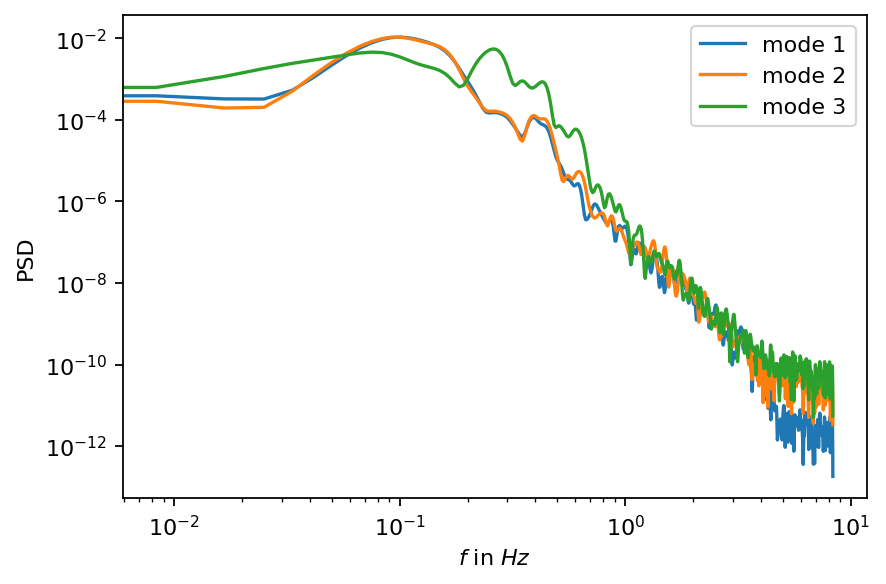

In [85]:
dt = times_num[1] - times_num[0]
for i in range(1, n_plot):
    f, a = welch(svd.V[:, i].numpy(), fs=1/dt.item(), nperseg=int(n_times/2), nfft=n_times*2)
    plt.plot(f, a, label=f"mode {i}")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel(r"$f$ in $Hz$")
plt.ylabel(r"PSD")
plt.show()

### Dynamic mode decomposition

In [86]:
dmd = DMD(dmw, dt=dt, optimal=True)
print(dmd)

SVD:
SVD of a 105462x435 data matrix
Selected/optimal rank: 435/435
data type: torch.float32 (4b)
truncated SVD size: 176.6607Mb
LSQ:
Overall DMD size: 528.1135Mb


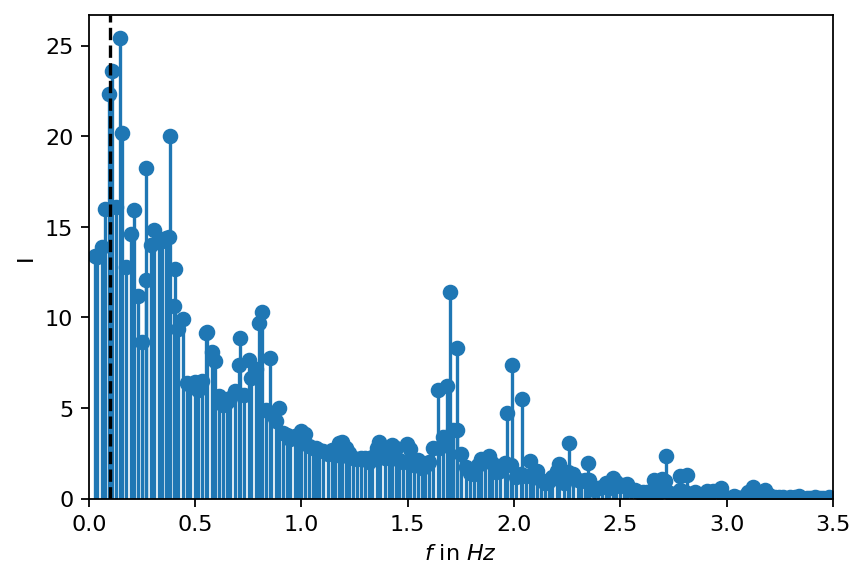

In [97]:
freq = dmd.frequency
pos = freq > 0.0
imp = dmd.integral_contribution
plt.stem(freq[pos].numpy(), imp[pos].numpy(), basefmt="none")
plt.axvline(0.1, ls="--", c="k")
plt.xlabel(r"$f$ in $Hz$")
plt.ylabel(r"I")
plt.xlim(0, 3.5)
plt.ylim(0)
plt.show()

In [110]:
def select_top_in_range(topk, lb, ub):
    in_range = [i for i in topk if lb < dmd.frequency[i].item() < ub]
    return in_range[0]

topk = dmd.top_modes(200, integral=True)
# background mode
bg = select_top_in_range(topk, -5, 5)
# vortex shedding mode
lowf = select_top_in_range(topk, 0, 1)
# higher frequency modes
highf = select_top_in_range(topk, 1.5, 1.8)

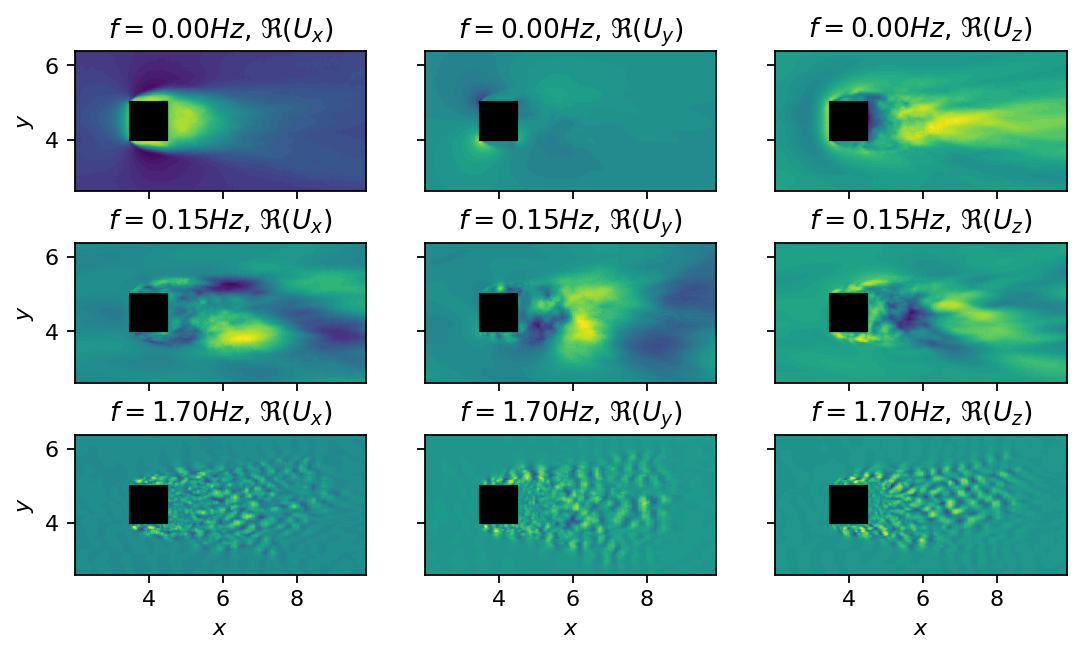

In [112]:
fig, axarr = plt.subplots(3, 3, figsize=(8, 1.5*3), sharex=True, sharey=True)
for i, mi in enumerate([bg, lowf, highf]):
    axarr[i, 0].tricontourf(x, y, dmd.modes[:n_points, mi].real/area, levels=50)
    axarr[i, 1].tricontourf(x, y, dmd.modes[n_points:2*n_points, mi].real/area, levels=50)
    axarr[i, 2].tricontourf(x, y, dmd.modes[2*n_points:, mi].real/area, levels=50)
    for ax in axarr[i, :]:
        ax.set_aspect("equal")
        cube = Rectangle((3.5, 4), 1, 1, linewidth=1, edgecolor="k", facecolor="k")
        ax.add_patch(cube)
        axarr[i, 0].set_ylabel(r"$y$")
    axarr[i, 0].set_title(f"$f= {dmd.frequency[mi].item():2.2f} Hz$, $\Re(U_x)$")
    axarr[i, 1].set_title(f"$f= {dmd.frequency[mi].item():2.2f} Hz$, $\Re(U_y)$")
    axarr[i, 2].set_title(f"$f= {dmd.frequency[mi].item():2.2f} Hz$, $\Re(U_z)$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$x$")
plt.show()

### Animate reconstructed modes

In [135]:
def animate_reconstruction(reconstruction, title, n_frames):
    vmin, vmax = reconstruction.min(), reconstruction.max()
    fig, ax = plt.subplots(figsize=(7, 4), dpi=640)
    plt.subplots_adjust(bottom=0.2, top=0.85, left=0.1, right=0.95)
    def animate(i):
        print("\r", f"frame {i:03d}", end="")
        ax.clear()
        tri = ax.tricontourf(x, y, reconstruction[:, i], levels=50, cmap="seismic", vmin=vmin*1.0/0.98, vmax=vmax*0.98)
        ax.set_aspect("equal")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        ax.set_title(title)
        cube = Rectangle((3.5, 4), 1, 1, linewidth=1, edgecolor="k", facecolor="k")
        ax.add_patch(cube)
        #ax.set_xlim(-0.2, 2.0)
        #ax.set_ylim(-0.3, 1.0)
    return FuncAnimation(fig, animate,  frames=n_frames, repeat=True)

In [136]:
writer = FFMpegWriter(fps=15, bitrate=1800)

In [137]:
vel_mag = (vel[0]**2 + vel[1]**2 + vel[2]**2).sqrt()
anim = animate_reconstruction(vel_mag[:, :500], r"$||\mathbf{u}||$", 500)
plt.close()
anim.save(join(output, f"vel_mag.mp4"), writer=writer)

 frame 499

In [138]:
def find_conj_complex(mi):
    return (dmd.frequency.abs() - dmd.frequency[mi]).abs().topk(2, largest=False).indices

In [158]:
# this is just a little hack to create nicer animations
# dmd._eigvals /= dmd._eigvals.abs()

In [161]:
lowfr = pt.cat((find_conj_complex(lowf), bg.unsqueeze(-1)), dim=0).tolist()
r = dmd.partial_reconstruction({*lowfr}) / area.repeat(3).unsqueeze(-1)
rmag = (r[:n_points]**2 + r[n_points:2*n_points]**2 + r[2*n_points:]**2).sqrt()
anim = animate_reconstruction(rmag[:, :500], r"$||\mathbf{u}||$" + f", $f={freq[lowf]:2.2f}Hz$", 500)
plt.close()
anim.save(join(output, f"vel_mag_lowf.mp4"), writer=writer)

 frame 499

In [162]:
highfr = pt.cat((find_conj_complex(highf), bg.unsqueeze(-1)), dim=0).tolist()
r = dmd.partial_reconstruction({*highfr}) / area.repeat(3).unsqueeze(-1)
rmag = (r[:n_points]**2 + r[n_points:2*n_points]**2 + r[2*n_points:]**2).sqrt()
anim = animate_reconstruction(rmag[:, :500], r"$||\mathbf{u}||$" + f", $f={freq[highf]:2.2f}Hz$", 500)
plt.close()
anim.save(join(output, f"vel_mag_highf.mp4"), writer=writer)

 frame 499

## What's next?

- repeat the analysis with the
  - $x$-$z$-plane data
  - $y$-$z$-plane data
  - cube surface data
- compare 2D and 3D modes (OpenFOAM)